# Billboard Chart -- Data Analysis

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Load and inspect the dataset:

In [85]:
music = pd.read_csv('assets/billboard.csv')

In [86]:
type(music)

pandas.core.frame.DataFrame

In [87]:
music.head(2)

,year,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,2000,Destiny's Child,Independent Women Part I,"3,38,00 AM",Rock,"September 23, 2000","November 18, 2000",78,63,49,...,*,*,*,*,*,*,*,*,*,*
1,2000,Santana,"Maria, Maria","4,18,00 AM",Rock,"February 12, 2000","April 8, 2000",15,8,6,...,*,*,*,*,*,*,*,*,*,*


In [88]:
len(music.columns)

83

Yikes, we'll have to deal with those.

In [89]:
music.dtypes[0:8]

year                int64
artist.inverted    object
track              object
time               object
genre              object
date.entered       object
date.peaked        object
x1st.week           int64
dtype: object

In [90]:
music['year'].value_counts()

2000    317
Name: year, dtype: int64

They're all the same, get rid.

In [91]:
del music['year']

If this difference is not zero then we have multiple songs by at least one artist:

In [9]:
abs(len(music['artist.inverted'].unique()) - len(music['track'].unique()))

88

In [10]:
music['track'].value_counts(ascending = False).head(2)

Where I Wanna Be              2
If You Don't Wanna Love Me    1
Name: track, dtype: int64

In [11]:
music[music['track'] == 'Where I Wanna Be']

,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,x4th.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
118,"Jones, Donell",Where I Wanna Be,"6,22,00 AM",Rock,"April 22, 2000","July 8, 2000",81,71,65,50,...,*,*,*,*,*,*,*,*,*,*
305,"Sheist, Shade",Where I Wanna Be,"4,16,00 AM",Rap,"November 11, 2000","November 18, 2000",96,95,99,99,...,*,*,*,*,*,*,*,*,*,*


The only repeated title is attributed each time to a distinct artist, so we don't have to worry about duplicate observations.

Looks like we'll have to disambiguate "R&B" and "R & B," and perhaps combine "Rock" and "Rock'n'roll":

In [12]:
music['genre'].value_counts()

Rock           103
Country         74
Rap             58
Rock'n'roll     34
R&B             13
R & B           10
Pop              9
Latin            9
Electronica      4
Gospel           1
Jazz             1
Reggae           1
Name: genre, dtype: int64

Check out singletons:

In [13]:
music[(music['genre'] == 'Gospel') | (music['genre'] == 'Jazz') | (music['genre'] == 'Reggae')]\
[['artist.inverted', 'track', 'genre']]

,artist.inverted,track,genre
49,Kenny G,Auld Lang Syne (The Millenium Mix),Jazz
189,Beenie Man,Girls Dem Sugar,Reggae
200,"Adams, Yolanda",Open My Heart,Gospel


In [14]:
music['time'].max() 

'7,50,00 AM'

In [15]:
music.index

RangeIndex(start=0, stop=317, step=1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This data frame contains information regarding songs hitting the Billboard chart in the year 2000.  It has 317 rows and 83 columns.  Artist names are in "Last/First" form (where applicable).  Two songs of the same title are performed by different artists.  Track time is listed in an unwieldy combination of minutes and seconds.  Genre names require disambiguation in the cases of, "R&B," and, "R & B," as well as, "Rock," and, "Rock'n'roll."  The "date.entered" and "date.peaked" columns will have to be converted to datetime format if we want to use them to calculate time elapsed.  Likewise, with the week columns we will have to figure what information we want to extract from them and combine with datetime information if needed.

### Clean dataset:

In [16]:
def prettify_name(artist):
    try:
        name = artist.split(', ')
        new_name = "%s" %name[1] + " %s" %name[0]
    except:
        new_name = artist
    return new_name

In [17]:
new_names = []
for i in range(len(music['artist.inverted'])):
    if ',' in music['artist.inverted'][i]:
        name = prettify_name(music['artist.inverted'][i])
        new_names.append(name)
    else:
        new_names.append(music['artist.inverted'][i])
        continue
        
new_names[0:9]

["Destiny's Child",
 'Santana',
 'Savage Garden',
 'Madonna',
 'Christina Aguilera',
 'Janet',
 "Destiny's Child",
 'Enrique Iglesias',
 'Sisqo']

In [18]:
music['artist.inverted'] = new_names
music.rename(columns={'artist.inverted':'artist'}, inplace=True)
music.head(5)

,artist,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,x4th.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,Destiny's Child,Independent Women Part I,"3,38,00 AM",Rock,"September 23, 2000","November 18, 2000",78,63,49,33,...,*,*,*,*,*,*,*,*,*,*
1,Santana,"Maria, Maria","4,18,00 AM",Rock,"February 12, 2000","April 8, 2000",15,8,6,5,...,*,*,*,*,*,*,*,*,*,*
2,Savage Garden,I Knew I Loved You,"4,07,00 AM",Rock,"October 23, 1999","January 29, 2000",71,48,43,31,...,*,*,*,*,*,*,*,*,*,*
3,Madonna,Music,"3,45,00 AM",Rock,"August 12, 2000","September 16, 2000",41,23,18,14,...,*,*,*,*,*,*,*,*,*,*
4,Christina Aguilera,Come On Over Baby (All I Want Is You),"3,38,00 AM",Rock,"August 5, 2000","October 14, 2000",57,47,45,29,...,*,*,*,*,*,*,*,*,*,*


Clean up repeat genre names:

In [19]:
music['genre'] = music['genre'].apply(lambda x: x.replace('Rock\'n\'roll', 'Rock'))
music['genre'] = music['genre'].apply(lambda x: x.replace('R & B', 'R&B'))
music['genre'] = music['genre'].apply(lambda x: x.replace('R&B', 'RnB'))
music['genre'] = music['genre'].astype('category')
music['genre'].value_counts()

Rock           137
Country         74
Rap             58
RnB             23
Pop              9
Latin            9
Electronica      4
Reggae           1
Jazz             1
Gospel           1
Name: genre, dtype: int64

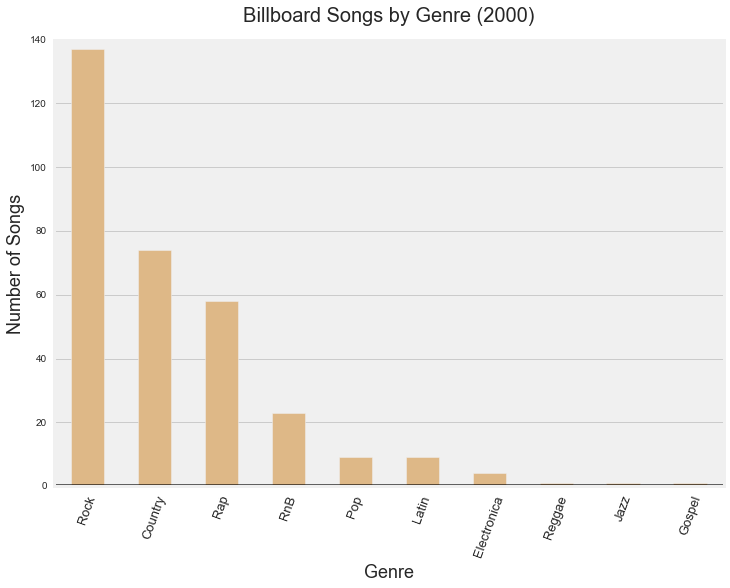

In [20]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

y = pd.DataFrame(music['genre'].value_counts())

y['genre'].plot.bar(color = 'burlywood')

plt.title('Billboard Songs by Genre (2000)', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Number of Songs', fontsize = 18)

# x label
plt.xlabel('Genre', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=70, fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.show()

So, lots of rock songs!  Followed by rap and country.  Interesting...

Let's make a column explicitly for entering chart position (we'll use it to calculate time to peak position, soon):

In [21]:
music['entering.position'] = music['x1st.week'].apply(lambda x: float(x))

Clean column of track lengths:

In [22]:
music['time'] = music['time'].apply(lambda x: x.replace(',00 AM', ''))

In [23]:
def get_sec(s):
    '''This function converts a comma-separated string of minutes and seconds into a value \
    of seconds only'''
    try:
        time = s.split(',')
        new_s = float(int(time[0]) * 60 + int(time[1]))
    except:
        new_s = s
    return new_s

In [24]:
music['time'] = music['time'].apply(lambda x: get_sec(x))
music.head(2)

,artist,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,x4th.week,...,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week,entering.position
0,Destiny's Child,Independent Women Part I,218.0,Rock,"September 23, 2000","November 18, 2000",78,63,49,33,...,*,*,*,*,*,*,*,*,*,78.0
1,Santana,"Maria, Maria",258.0,Rock,"February 12, 2000","April 8, 2000",15,8,6,5,...,*,*,*,*,*,*,*,*,*,15.0


Change dates to pandas datetime objects and difference as needed to calculate weeks to peak position:

In [25]:
music['date.entered'] = music['date.entered'].apply(lambda x: pd.to_datetime(x))
music['date.peaked'] = music['date.peaked'].apply(lambda x: pd.to_datetime(x))

In [26]:
music['weeks.to.peak'] = ((music['date.peaked']-music['date.entered'])/7)\
                                                            .apply(lambda x: float(x.days))
music['weeks.to.peak'].head()

0     8.0
1     8.0
2    14.0
3     5.0
4    10.0
Name: weeks.to.peak, dtype: float64

In [27]:
music.head(1)

,artist,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,x4th.week,...,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week,entering.position,weeks.to.peak
0,Destiny's Child,Independent Women Part I,218.0,Rock,2000-09-23,2000-11-18,78,63,49,33,...,*,*,*,*,*,*,*,*,78.0,8.0


## Visualize Data

Find peak position attained by each track:

In [28]:
music_weeks = music.drop(['artist', 'track', 'genre', 'time', 'entering.position', \
                    'weeks.to.peak', 'date.entered', 'date.peaked'], axis=1, inplace=False)
music_weeks = music_weeks.replace('*', 'NaN')    
music_weeks = music_weeks.applymap(lambda x: float(x))

peak_pos = []
for i in range(len(music_weeks)):
    pos = music_weeks.iloc[i, :].min()
    peak_pos.append(pos)

music['peak.position'] = peak_pos
del music_weeks, peak_pos

In [29]:
music = music[['artist', 'track', 'genre', 'time', 'entering.position', 'weeks.to.peak', \
               'peak.position', 'date.entered', 'date.peaked']]
music.head(1)

,artist,track,genre,time,entering.position,weeks.to.peak,peak.position,date.entered,date.peaked
0,Destiny's Child,Independent Women Part I,Rock,218.0,78.0,8.0,1.0,2000-09-23,2000-11-18


In [30]:
music.tail(1)

,artist,track,genre,time,entering.position,weeks.to.peak,peak.position,date.entered,date.peaked
316,Fragma,Toca's Miracle,RnB,202.0,99.0,0.0,99.0,2000-10-28,2000-10-28


In [31]:
music[['artist', 'track', 'genre', 'peak.position']].sort_values('peak.position', axis=0, \
                ascending=True, inplace=False, kind='quicksort', na_position='last').head()

,artist,track,genre,peak.position
0,Destiny's Child,Independent Women Part I,Rock,1.0
16,Mariah Carey,Thank God I Found You,Rock,1.0
15,matchbox twenty,Bent,Rock,1.0
14,Aaliyah,Try Again,Rock,1.0
13,Creed,With Arms Wide Open,Rock,1.0


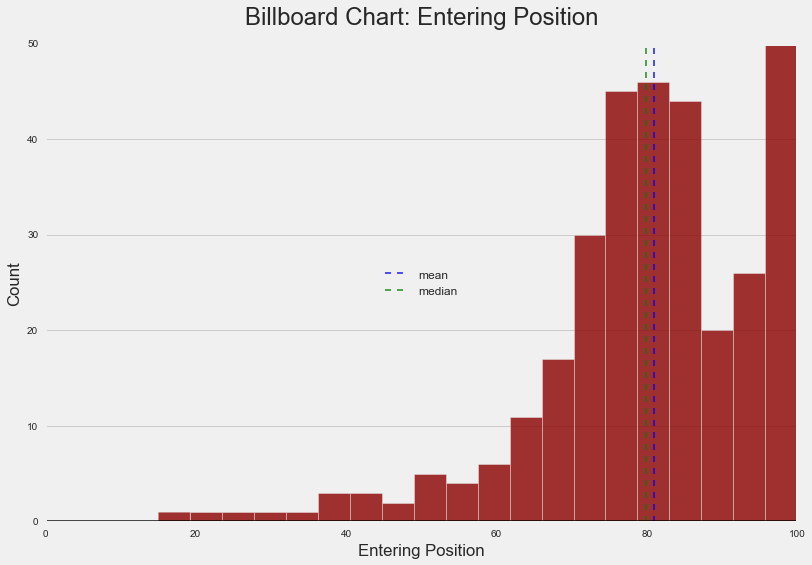

In [36]:
## Plot a histogram of entering chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

music_hist = plt.hist(music['entering.position'], color = 'darkred', bins = 20, alpha = 0.8)

plt.axvline(music['entering.position'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['entering.position'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Entering Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Entering Position')

# legend
plt.legend(loc='center', fontsize = 12)

plt.xlim([0, 100])
#plt.ylim([0, 60])

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black', alpha = 0.7)

plt.show()

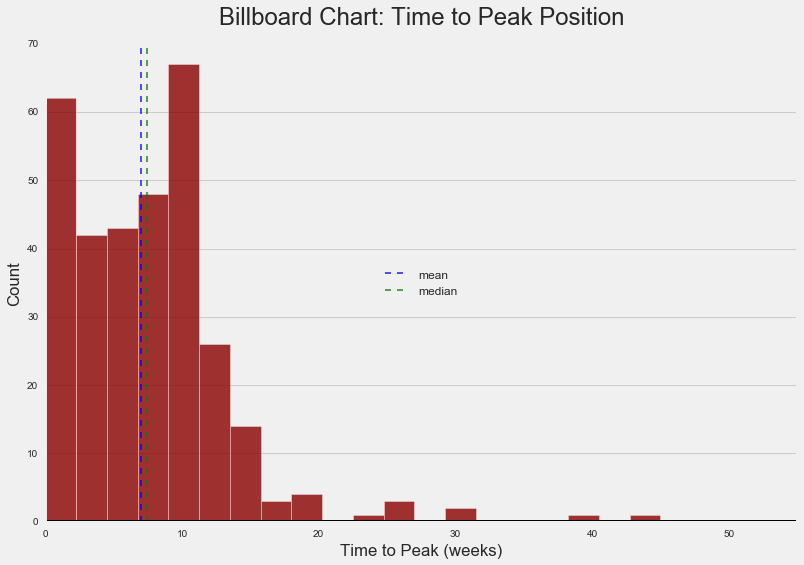

In [37]:
## Plot a histogram of time to peak chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

music_hist = plt.hist(music['weeks.to.peak'], color = 'darkred', bins = 20, alpha = 0.8)

plt.axvline(music['weeks.to.peak'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['weeks.to.peak'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Time to Peak Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Time to Peak (weeks)')

# legend
plt.legend(loc='center', fontsize = 12)

plt.xlim([0, 55])
#plt.ylim([0, 60])

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

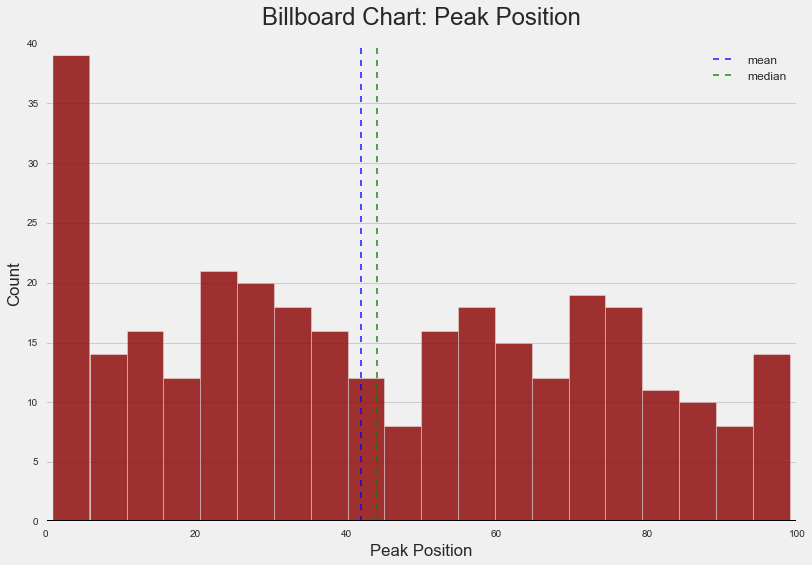

In [38]:
## Plot a histogram of peak chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

music_hist = plt.hist(music['peak.position'], color = 'darkred', bins = 20, alpha = 0.8)

plt.axvline(music['peak.position'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['peak.position'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Peak Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Peak Position')

# legend
plt.legend(loc='upper right', fontsize = 12)

#plt.xlim([0, 55])
#plt.ylim([0, 60])

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

This histogram is all over the place!  It appears fairly uniformly distributed except for a spike near the very top chart positions, which probably has to do with marketing and advance hype of certain albums/songs.

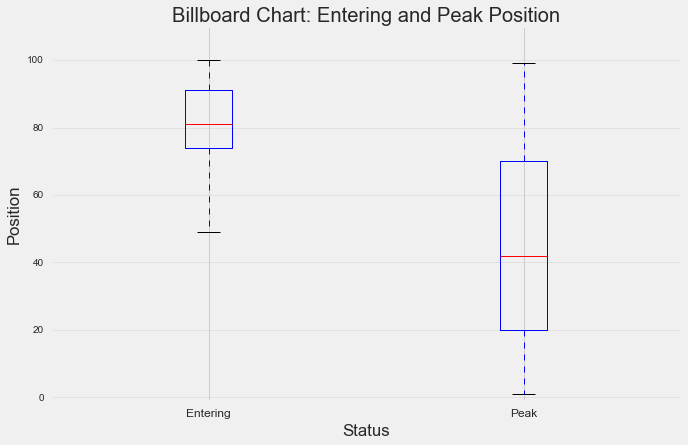

In [39]:
data = [music['entering.position'], music['peak.position']]
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(10, 8))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Entering and Peak Position')
ax1.set_xlabel('Status')
ax1.set_ylabel('Position')

# Set the axes ranges and axes labels
numBoxes = 2
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 110)
xtickNames = plt.setp(ax1, xticklabels=['Entering', 'Peak'])
plt.setp(xtickNames, fontsize=12)

plt.show()

## http://matplotlib.org/examples/pylab_examples/boxplot_demo2.html

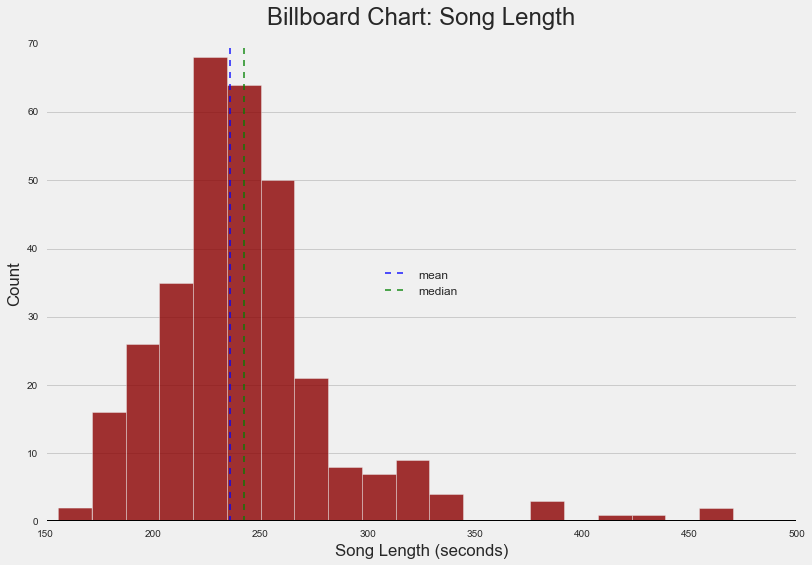

In [40]:
## Plot a histogram of song length 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

music_hist = plt.hist(music['time'], color = 'darkred', bins = 20, alpha = 0.8)

plt.axvline(music['time'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['time'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Song Length', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Song Length (seconds)')

# legend
plt.legend(loc='center', fontsize = 12)

#plt.xlim([0, 55])
#plt.ylim([0, 60])

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

In [41]:
## These are all songs longer than 350 seconds
music[music['time'] > 350][['artist', 'track', 'genre', 'time']]

,artist,track,genre,time
49,Kenny G,Auld Lang Syne (The Millenium Mix),Jazz,470.0
100,D'Angelo,Untitled (How Does It Feel),RnB,430.0
109,Alice Deejay,Better Off Alone,Electronica,410.0
118,Donell Jones,Where I Wanna Be,Rock,382.0
128,Enrique Iglesias,Rhythm Divine,Latin,455.0
229,Kelly Price,As We Lay,Rock,380.0
282,Dave Hollister,Can't Stay,Rock,377.0


In [42]:
## These are all songs taking longer than 150 days to reach peak chart position
music[music['weeks.to.peak'] > 20][['artist', 'track', 'genre', 'weeks.to.peak']]

,artist,track,genre,weeks.to.peak
9,Lonestar,Amazed,Country,39.0
12,Vertical Horizon,Everything You Want,Rock,25.0
13,Creed,With Arms Wide Open,Rock,26.0
17,Faith Hill,Breathe,Rap,24.0
24,3 Doors Down,Kryptonite,Rock,31.0
28,Joe,I Wanna Know,Rock,26.0
46,Creed,Higher,Rock,45.0
157,Amber,Sexual (Li Da Di),Rock,30.0


In [43]:
## These are all songs entering the chart at position 30 or higher (lower numerical value \
## being a higher ranking) 
music[music['entering.position'] < 30][['artist', 'track', 'genre', 'entering.position']]

,artist,track,genre,entering.position
1,Santana,"Maria, Maria",Rock,15.0
45,Pink,There U Go,Rock,25.0
80,Hanson,This Time Around,Country,22.0
114,Mariah Carey,Crybaby,Rock,28.0


Create a genre-color dictionary:

In [44]:
colors = {'Rock' : 'Red', 
          'Country' : 'Orange', 
          'Rap' : 'Yellow', 
          'RnB' : 'Green', 
          'Electronica' : 'Violet', 
          'Latin' : 'Indigo', 
          'Pop' : 'Blue', 
          'Reggae' : 'DarkGrey', 
          'Jazz' : 'DimGrey', 
          'Gospel' : 'LightGrey'}

genre_list = ['Rock', 'Country', 'Rap', 'RnB', 'Pop', 'Latin', 'Electronica', 'Jazz', \
              'Reggae', 'Gospel']

In [48]:
def rand_jitter(arr):
    stdev = .003*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=10, marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, \
           linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, marker=marker, cmap=cmap, \
            norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, \
            hold=hold, **kwargs)

## jitter assistance from:
## http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints\
## -in-a-scatter-dot-beeswarm-plot

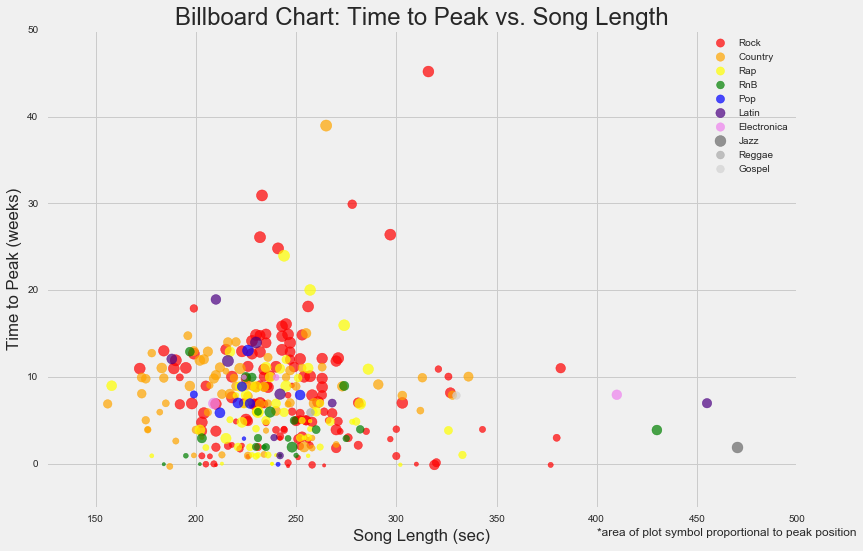

In [49]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

peak_area = []
for peak_pos in music['peak.position']:
    x = 100 - peak_pos
    new_peak = ((125 - 10)*(x - min(100 - music['peak.position'])) / \
            (max(100 - music['peak.position']) - min(100 - music['peak.position']))) + 10
    peak_area.append(new_peak)
    
music['peak.area'] = peak_area

del peak_area

for i in genre_list:
    y = music[music['genre'] == i]
    plt.scatter(y['time'], rand_jitter(y['weeks.to.peak']), \
                color = colors[i], alpha = 0.7, s = y['peak.area'], label = i)

plt.title('Billboard Chart: Time to Peak vs. Song Length', fontsize = 24)

# y label
plt.ylabel('Time to Peak (weeks)')

# x label
plt.xlabel('Song Length (sec)')

# set the figure boundaries
plt.xlim([125, 500])
plt.ylim([-5, 50])

plt.legend(loc='upper right', fontsize = 10)

plt.annotate('*area of plot symbol proportional to peak position', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

plt.show()

Let's zoom in to get a closer look at the cluster above:

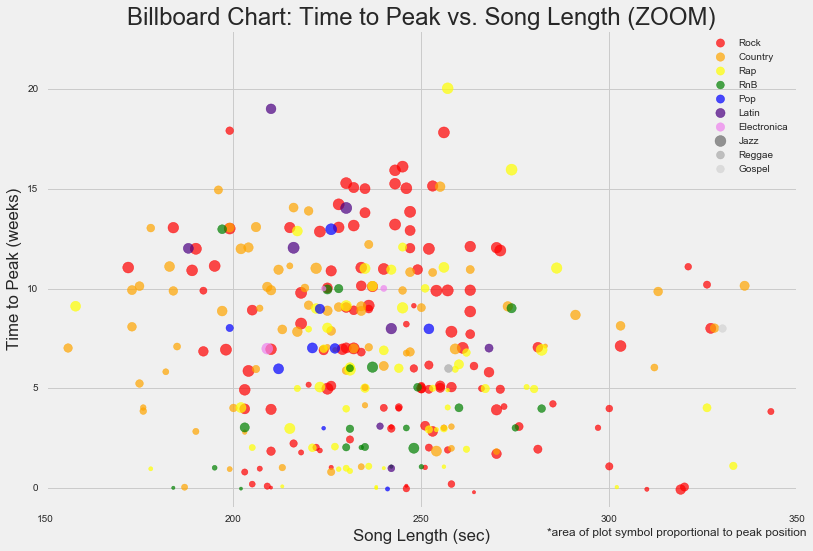

In [50]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

peak_area = []
for peak_pos in music['peak.position']:
    x = 100 - peak_pos
    new_peak = ((125 - 10)*(x - min(100 - music['peak.position'])) / \
            (max(100 - music['peak.position']) - min(100 - music['peak.position']))) + 10
    peak_area.append(new_peak)
    
music['peak.area'] = peak_area

del peak_area

for i in genre_list:
    y = music[music['genre'] == i]
    plt.scatter(y['time'], rand_jitter(y['weeks.to.peak']), \
                color = colors[i], alpha = 0.7, s = y['peak.area'], label = i)

plt.title('Billboard Chart: Time to Peak vs. Song Length (ZOOM)', fontsize = 24)

# y label
plt.ylabel('Time to Peak (weeks)')

# x label
plt.xlabel('Song Length (sec)')

# set the figure boundaries
plt.xlim([150, 350])
plt.ylim([-1, 23])

plt.legend(loc='upper right', fontsize = 10)

plt.annotate('*area of plot symbol proportional to peak position', (1,0), (-250, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

plt.show()

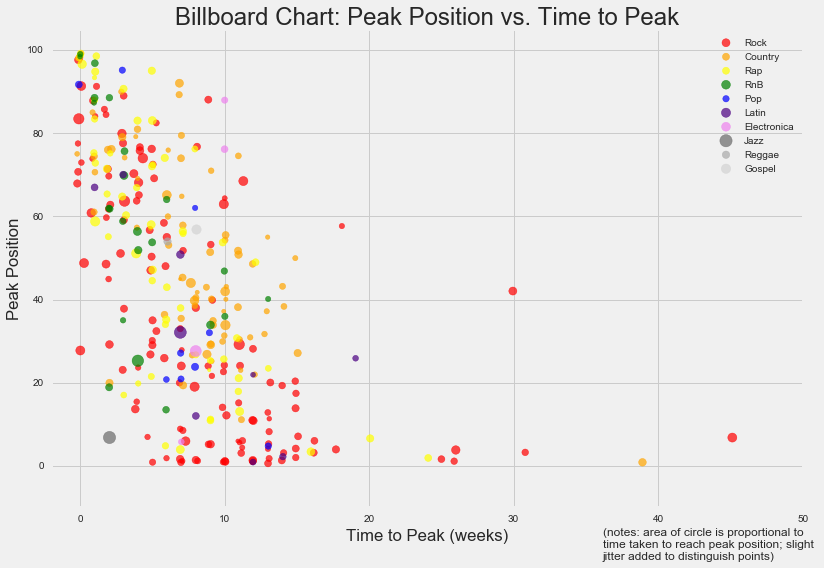

In [61]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

time_area = []
for time in music['time']:
    new_time = ((150 - 10)*(time - min(music['time'])) / \
            (max(music['time']) - min(music['time']))) + 10
    time_area.append(new_time)
    
music['time.area'] = time_area

del time_area

for i in genre_list:
    y = music[music['genre'] == i]
    plt.scatter(rand_jitter(y['weeks.to.peak']), rand_jitter(y['peak.position']), \
                color = colors[i], alpha = 0.7, \
                s = y['time.area'], \
                label = i)

plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24)

# y label
plt.ylabel('Peak Position')

# x label
plt.xlabel('Time to Peak (weeks)')

# set the figure boundaries
plt.xlim([-2, 50])
plt.ylim([-10, 105])

plt.legend(loc='upper right', fontsize = 10)

plt.annotate('(notes: area of circle is proportional to \ntime taken to reach \
peak position; slight \njitter added to distinguish points)', (1,0), \
             (-200, -20), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 12)

plt.show()

This is a visually busy histogram so I'm just commenting it out for now...

In [62]:
# plt.figure(figsize=(12,8))
# plt.style.use('fivethirtyeight')

# for i in genre_dict.keys():
#     y = music[music['genre'] == i]
#     plt.hist(y['time'], color = genre_dict[i], alpha = 0.3, bins = 15)
#     plt.axvline(y['time'].median(), color=genre_dict[i], linestyle='dashed', \
#             linewidth=1, label = str(i) + ', mean', alpha = 0.9)
#     plt.axvline(y['time'].mean(), color=genre_dict[i], linestyle='solid', \
#             linewidth=1, label = str(i) + ', median', alpha = 0.9)

# plt.title('Billboard Chart: Time to Peak vs. Song Length', fontsize = 24)

# # y label
# plt.ylabel('Time to Peak (weeks)')

# # x label
# plt.xlabel('Song Length (sec)')

# # set the figure boundaries
# # plt.xlim([125, 500])
# # plt.ylim([-5, 50])

# plt.legend(loc='upper right', fontsize = 10)

# plt.annotate('*area of plot symbol proportional to peak position', (1,0), (-200, -20), \
#              xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

# plt.show()

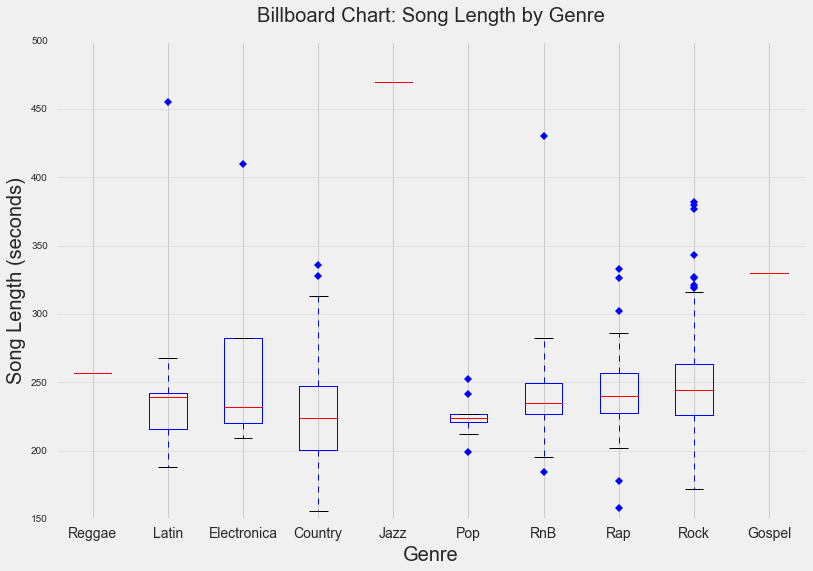

In [63]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

data = [music[music['genre'] == 'Reggae']['time'], \
        music[music['genre'] == 'Latin']['time'], \
        music[music['genre'] == 'Electronica']['time'],
        music[music['genre'] == 'Country']['time'],
        music[music['genre'] == 'Jazz']['time'],
        music[music['genre'] == 'Pop']['time'],
        music[music['genre'] == 'RnB']['time'],
        music[music['genre'] == 'Rap']['time'],
        music[music['genre'] == 'Rock']['time'],
        music[music['genre'] == 'Gospel']['time']]

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Song Length by Genre', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Song Length (seconds)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
#ax1.set_ylim(0, 45)
xtickNames = plt.setp(ax1, xticklabels=['Reggae', 'Latin', 'Electronica', 'Country', \
                                'Jazz', 'Pop', 'RnB', 'Rap', 'Rock', 'Gospel'])
plt.setp(xtickNames, fontsize=14)

del data

plt.show()

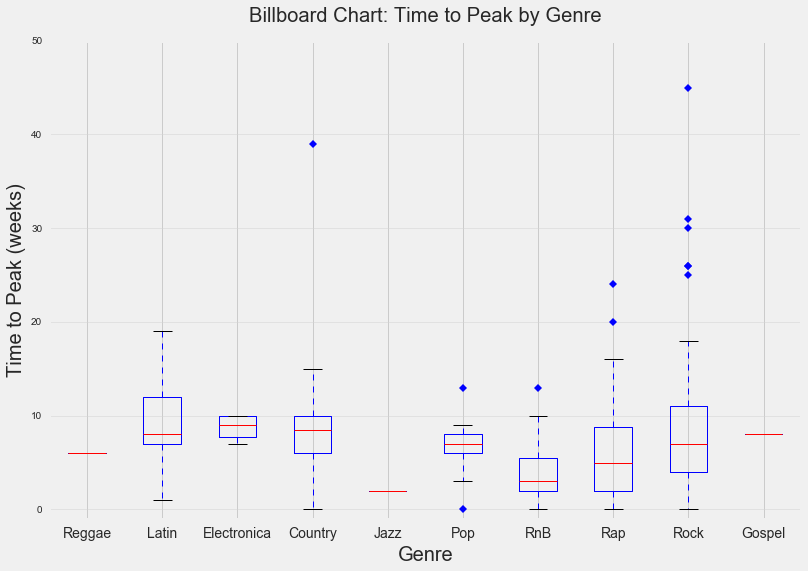

In [64]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

data = [music[music['genre'] == 'Reggae']['weeks.to.peak'], \
        music[music['genre'] == 'Latin']['weeks.to.peak'], \
        music[music['genre'] == 'Electronica']['weeks.to.peak'],
        music[music['genre'] == 'Country']['weeks.to.peak'],
        music[music['genre'] == 'Jazz']['weeks.to.peak'],
        music[music['genre'] == 'Pop']['weeks.to.peak'],
        music[music['genre'] == 'RnB']['weeks.to.peak'],
        music[music['genre'] == 'Rap']['weeks.to.peak'],
        music[music['genre'] == 'Rock']['weeks.to.peak'],
        music[music['genre'] == 'Gospel']['weeks.to.peak']]

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Time to Peak by Genre', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Time to Peak (weeks)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 50)
xtickNames = plt.setp(ax1, xticklabels=['Reggae', 'Latin', 'Electronica', 'Country', \
                                'Jazz', 'Pop', 'RnB', 'Rap', 'Rock', 'Gospel'])
plt.setp(xtickNames, fontsize=14)

del data

plt.show()

#### Clean the data:

In [65]:
new_music = music[music['genre'] != 'Reggae']
new_music = new_music[new_music['genre'] != 'Gospel']
new_music = new_music[(new_music['time'] < 350) & (new_music['weeks.to.peak'] < 20)]

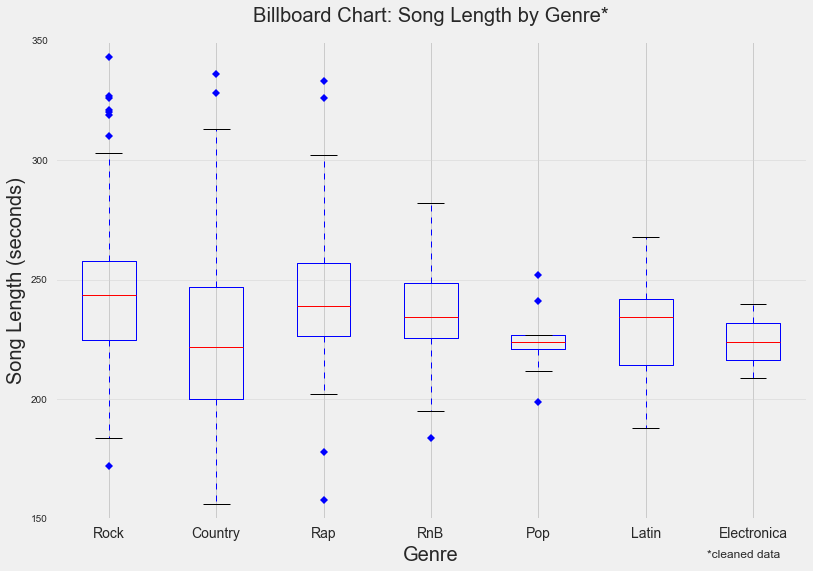

In [66]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

data = [new_music[new_music['genre'] == 'Rock']['time'], \
        new_music[new_music['genre'] == 'Country']['time'],
        new_music[new_music['genre'] == 'Rap']['time'],
        new_music[new_music['genre'] == 'RnB']['time'],
        new_music[new_music['genre'] == 'Pop']['time'],
        new_music[new_music['genre'] == 'Latin']['time'],
        new_music[new_music['genre'] == 'Electronica']['time']]

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Song Length by Genre*', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Song Length (seconds)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(new_music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
#ax1.set_ylim(0, 45)
xtickNames = plt.setp(ax1, xticklabels=['Rock', 'Country', 'Rap', 'RnB', 'Pop', \
                                        'Latin', 'Electronica'])
plt.setp(xtickNames, fontsize=14)

del data

plt.annotate('*cleaned data', (1,0), (-100, -30), xycoords='axes fraction', \
             textcoords='offset points', va='top', fontsize = 12)

plt.show()

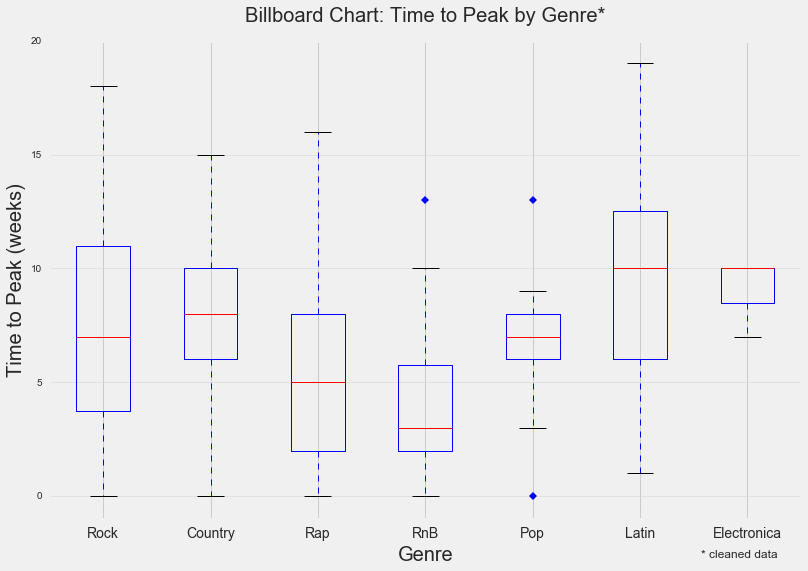

In [67]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')

data = [new_music[new_music['genre'] == 'Rock']['weeks.to.peak'], \
        new_music[new_music['genre'] == 'Country']['weeks.to.peak'],
        new_music[new_music['genre'] == 'Rap']['weeks.to.peak'],
        new_music[new_music['genre'] == 'RnB']['weeks.to.peak'],
        new_music[new_music['genre'] == 'Pop']['weeks.to.peak'],
        new_music[new_music['genre'] == 'Latin']['weeks.to.peak'],
        new_music[new_music['genre'] == 'Electronica']['weeks.to.peak']]

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Time to Peak by Genre*', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Time to Peak (weeks)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(new_music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 20)
xtickNames = plt.setp(ax1, xticklabels=['Rock', 'Country', 'Rap', 'RnB', 'Pop', \
                                        'Latin', 'Electronica'])
plt.setp(xtickNames, fontsize=14)

del data

plt.annotate('* cleaned data', (1,0), (-100, -30), xycoords='axes fraction', \
             textcoords='offset points', va='top', fontsize = 12)

plt.show()

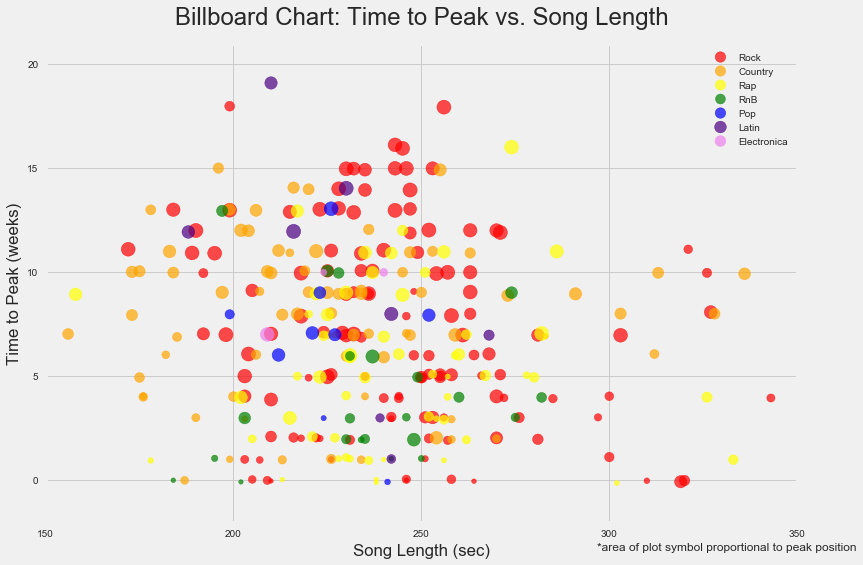

In [68]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

peak_area = []
for peak_pos in new_music['peak.position']:
    x = 100 - peak_pos
    new_peak = ((200 - 20)*(x - min(100 - new_music['peak.position'])) / \
            (max(100 - new_music['peak.position']) - min(100 - new_music['peak.position']))) \
            + 20
    peak_area.append(new_peak)
    
new_music['peak.area'] = peak_area

del peak_area

for i in genre_list:
    try:
        y = new_music[new_music['genre'] == i]
        plt.scatter(y['time'], rand_jitter(y['weeks.to.peak']), \
                color = colors[i], alpha = 0.7, s = y['peak.area'], label = i)
    except:
        pass

plt.title('Billboard Chart: Time to Peak vs. Song Length', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Time to Peak (weeks)')

# x label
plt.xlabel('Song Length (sec)')

# set the figure boundaries
plt.xlim([150, 350])
plt.ylim([-2, 21])

plt.legend(loc='upper right', fontsize = 10)

plt.annotate('*area of plot symbol proportional to peak position', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

plt.show()

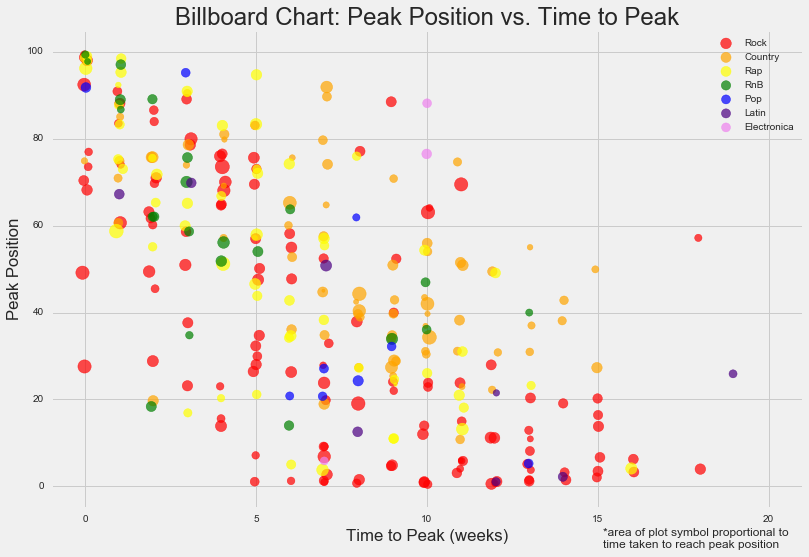

In [73]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

time_area = []
for time in new_music['time']:
    new_time = ((200 - 10)*(time - min(new_music['time'])) / \
            (max(new_music['time']) - min(new_music['time']))) + 10
    time_area.append(new_time)
    
new_music['time.area'] = time_area

del time_area

for i in genre_list:
    try:
        y = new_music[new_music['genre'] == i]
        plt.scatter(rand_jitter(y['weeks.to.peak']), rand_jitter(y['peak.position']), \
                    color = colors[i], alpha = 0.7, \
                    s = y['time.area'], \
                    label = i)
    except:
        pass

plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24)

# y label
plt.ylabel('Peak Position')

# x label
plt.xlabel('Time to Peak (weeks)')

# set the figure boundaries
plt.xlim([-1, 21])
plt.ylim([-5, 105])

plt.legend(loc='upper right', fontsize = 10)

plt.annotate('*area of plot symbol proportional to \ntime taken to reach peak position', \
             (1,0), (-200, -20), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 12)

plt.show()

We hypothesize that there is a linear relationship at a 0.05 significance level between the amount of time it takes a song to reach its peak position on the Billboard chart and the peak position itself.  We will test against the null hypothesis that the slope of the regression line is equal to zero.

For regression line: 

        y = Β0 + Β1x

H0: Β1 = 0

Ha: Β1 ≠ 0

In [80]:
## Let's look at the least squares regression line with the function I wrote in class

def regress(x, y):
    x_bar = float(sum(x))/len(x)
    y_bar = float(sum(y))/len(y)
    xy_bar = sum([x[i]*y[i] for i in range(len(x))])/len(x)
    x_sq_bar = sum([float(x[i])**2 for i in range(len(x))])/len(x)
    beta_hat = (xy_bar - (x_bar * y_bar)) / (x_sq_bar - x_bar**2)
    alpha = y_bar - beta_hat * x_bar

    #print "x_bar: %s" %x_bar
    #print "y_bar: %s" %y_bar
    #print "xy_bar: %s" %xy_bar
    #print "x^2 bar: %s" %x_sq_bar
    print "B1 (slope): %s" %beta_hat
    print "B0 (intercept): %s" %alpha

    plt.figure(figsize=(12,8))
    plt.style.use('fivethirtyeight')

    music_scatter = plt.scatter(rand_jitter(x), rand_jitter(y), alpha=0.5, \
                                color = 'red', s = music['time.area'])

    plt.title('Time to Peak vs. Peak Position', fontsize = 24, y = 1.03)

    plt.ylabel('Peak Position')

    plt.xlabel('Time to Peak (weeks)')
    
    ablineValues = []
    for i in x:
        ablineValues.append(beta_hat*i+alpha)
    
    plt.xlim([-1, 20])
    plt.ylim([-5, 105])

    plt.plot(x, ablineValues, linewidth = .4, color = "darkgreen")
    plt.show()
    
    return

In [81]:
new_music = new_music.reset_index(drop=True)

B1 (slope): -4.39315704429
B0 (intercept): 75.4192812636


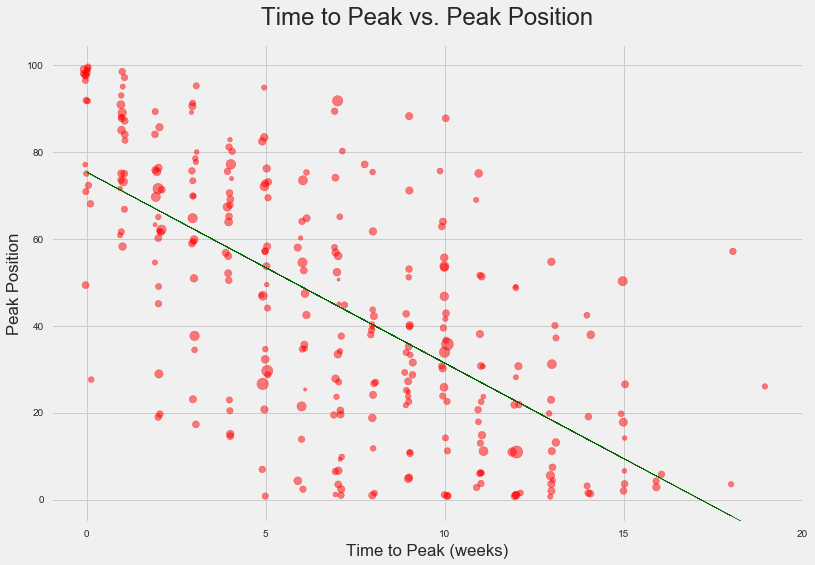

In [82]:
regress(new_music['weeks.to.peak'], new_music['peak.position'])

In [303]:
result = sm.OLS(music['peak.position'], music['weeks.to.peak']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          peak_position   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     95.54
Date:                Wed, 31 Aug 2016   Prob (F-statistic):           1.20e-19
Time:                        02:22:13   Log-Likelihood:                -1503.9
No. Observations:                 286   AIC:                             3010.
Df Residuals:                     285   BIC:                             3013.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
weeks_to_peak     3.2428      0.332      9.775      0.000         2.590     3.896
==============================================================================
Omnibus:                       35.543   Durbin-Watson:                   0.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.016
Skew:                           0.012   Prob(JB):                      0.00668
Kurtosis:                       2.084   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [304]:
from scipy.stats import linregress

results2 = linregress(music['weeks.to.peak'], music['peak.position'])
results2

LinregressResult(slope=-4.1799196372194478, intercept=74.136927845703468, rvalue=-0.66697221983138077, pvalue=3.5889635551454457e-38, stderr=0.27708015961766852)

Thus, at a 0.05 significance level with a p-value very near 0, we reject our null hypothesis that the peak position a song attains on the Billboard charts does not depend on the amount of time it takes to reach that position.  The shape of the plotted points makes sense intuitively (the longer a song is on the chart, the higher it will peak... something like listener momentum?  Or, if a song doesn't take very long to peak, it also isn't likely to leave very quickly afterward?).  